# Shuffles on S4

This code in Google Colab builds a Cayley Graph for a given generating set for the symmetric group on four letters. Then a Markov Chain on the Cayley Graph is created and visualized as a probability mass diffusing across the graph tending to a uniform distribution.

The second part of the code calculates the spectral gap and relaxation time and uses these to get upper and lower bounds on mixing times. Plots visualize the distance of the Markov chain to the uniform stationary distribution.

The third part compares mixing times for three Markov chains on three Cayley graphs associated with different methods of card shuffling. The spectral gaps and distance to the uniform stationary distribution are plotted indicating that the random transpositions shuffle is the fastest method of the three.

# Import packages

In [1]:
from itertools import permutations
import networkx as nx
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import time
from matplotlib import animation, rc
from matplotlib.animation import FuncAnimation
from scipy.optimize import curve_fit
from scipy.linalg import eigh

%xmode Plain
%pdb on

! git clone https://github.com/networkx/networkx.git
%cd networkx
%pip install -e .

Exception reporting mode: Plain
Automatic pdb calling has been turned ON
Cloning into 'networkx'...
remote: Enumerating objects: 51098, done.
remote: Counting objects: 100% (745/745), done.
remote: Compressing objects: 100% (481/481), done.
remote: Total 51098 (delta 423), reused 521 (delta 260), pack-reused 50353
Receiving objects: 100% (51098/51098), 17.98 MiB | 5.77 MiB/s, done.
Resolving deltas: 100% (35433/35433), done.
/content/networkx
Obtaining file:///content/networkx
ERROR: Command errored out with exit status 1: python setup.py egg_info Check the logs for full command output.


# Create helper functions

Create a function that will calculate the total variation distance between two probability vectors/distributions

In [2]:
def TV_dist(v, u):
  # This distance is just half of the sum of absolute differences in the entries
  return sum(abs(u-v))/2

Create a function that will calculate the distance from stationarity given a transition matrix and a stationary distribution

In [ ]:
def dist_to_stat(P, pis):
  # find the maximum over all rows of the total variation distance
  num_vertex = np.size(P, 0)
  tv_vector = np.zeros((num_vertex,))
  for i in range(num_vertex):
    e = TV_dist(P[i,:], pis)
    tv_vector[i] = e

  return max(tv_vector), P[np.argmax(tv_vector),:]

This function returns the stationary distribution corresponding to the simple random walk given by the transition matrix P. If the graph is regular, this is the uniform distribution

In [ ]:
def calc_stat_simple_walk(P):
  # convert matrix into 0's and 1's to count number of non-zero entries
  num_vertex = np.size(P, 0)
  num_edges = np.count_nonzero(P)/2

  # now fill in the stationary distribution which is proportional to the number of neighbors each vertex has
  pi0 = np.zeros((num_vertex,))

  for i in range(num_vertex):
    pi0[i] = np.count_nonzero(P[i,:])

  pis = pi0/(2*num_edges)

  return pis

Plot the TV distance to stationary over time

In [ ]:
def plot_dist(dist_vec, eps, upper_bound, lower_bound1, lower_bound2):
  print('\n')
  plt.figure(figsize=(10,9))
  x = [i+1 for i in range(len(dist_vec))]
  y = dist_vec
  plt.plot(x, y, '-o')
  plt.xlabel('Time steps/powers of transition matrix')
  plt.ylabel('d(t), maximum row TV distance to stationary distribution')
  plt.title('Mixing time, epsilon = ' + str(eps), fontsize=16, fontweight='bold')
  plt.xlim((0, upper_bound+5))
  plt.vlines(lower_bound1, 0, dist_vec[0], colors='black', label='Relaxation lower bound = ' + str(round(lower_bound1,2)))
  plt.vlines(upper_bound, 0, dist_vec[0], colors='black', label='Relaxation upper bound = ' + str(round(upper_bound,2)))
  plt.vlines(lower_bound2, 0, dist_vec[0], colors='red', label='Graph diameter lower bound = ' + str(round(lower_bound2,2)))
  plt.legend()
  plt.grid()
  plt.show()

Create a power function that will be used in a fitting

In [ ]:
def power_fun(x, C, alpha):
    return C * np.power(alpha, x)

Create a histrogram/bar chart for the given vertices and probabilities

In [ ]:
def histograms(vertices, probabilities):
  print('\n')
  plt.figure(figsize=(10,9))
  plt.bar(vertices, probabilities, color = 'orange')
  plt.title('Stationary distribution', fontsize=16, fontweight='bold')
  plt.xlabel('Vertices')
  plt.ylabel('Probabilities')
  plt.xticks(vertices, labels = [str(i) for i in range(num_perm)])

Calculate the mixing time for this Markov chain: the time it takes to be within epsilon TV distance of the stationary distribution

In [ ]:
def mixing_time(P, eps, pis):
  # will store the distance to stationary distribution at each time step
  dist_vec = []
  distributions = []

  # take powers of this matrix
  P_pow = P

  # get the distance to stationary from the original matrix
  dist, max_row = dist_to_stat(P, pis)
  distributions.append(max_row)

  # now take steps until we are close to stationary
  while dist > eps:
    P_pow = np.matmul(P_pow, P)
    dist, max_row = dist_to_stat(P_pow, pis)
    distributions.append(max_row)

    # store dist values in a vector so we can plot later
    dist_vec.append(dist)

  return dist_vec, distributions

Calculate the spectrum, spectral gap, relaxation time, and upper and lower bounds on mixing time

In [ ]:
def get_spectrum(P, eps, output=True):
  w_P, v_P = eigh(P)

  # these are the absolute spectral gaps
  lambda_star_P = 1 - max(abs(w_P[:-1]))

  # these are the spectral gaps, they will be equal to the absolute spectral gaps
  # if the chain is lazy
  lambda_P = 1 - max(w_P[:-1])

  # this is the relaxation time, which is one avenue to connect this to mixing times
  t_rel_P = 1/lambda_star_P

  # first upper bound
  upper_bound = np.log(1/(eps*(1/num_perm)))*t_rel_P

  # first lower bound
  lower_bound = (t_rel_P-1)*np.log(1/(2*eps))

  if output == 1:    
    print('Our eigenvalues of P are: ' + str(np.around(w_P[::-1], decimals=2)) + '\n')
    print('Our absolute spectral gap is: ' + str(round(lambda_star_P,2)) + '\n')
    print('Our spectral gap is: ' + str(round(lambda_P, 2)) + '\n')
    print('Our relaxation time is: ' + str(round(t_rel_P, 2)) + '\n')
    print('The upper bound on mixing time for eps=' + str(eps) + ' is: ' + str(round(upper_bound,2)) + '\n')
    print('The lower bound on mixing time for eps=' + str(eps) + ' is: ' + str(round(lower_bound,2)) + '\n')

    fig = plt.figure(figsize=(10,9))
    ax = plt.axes()

    x = np.linspace(1, num_perm, num=num_perm)
    ax.plot(x, w_P[::-1], marker='o')
    plt.xlabel('Eigenvalue Number')
    plt.ylabel('Eigenvalue')
    plt.title('Sorted Eigenvalues With Multiplicty', fontsize=16, fontweight='bold')
    plt.grid()

  return (lambda_star_P, lambda_P, t_rel_P, upper_bound, lower_bound, w_P)

Parse the input and create a list of generators

In [ ]:
def create_generators(generators_str):
  if generators_str == '1':
    generators = [[2,1,3,4], [3,2,1,4], [4,2,3,1], [1,3,2,4], [1,4,3,2], [1,2,4,3]]
    generators_str = '{[2134],[3214],[4231],[1324],[1432],[1243]}'
  elif generators_str == '2':
    generators = [[2,1,3,4], [3,2,1,4], [4,2,3,1]]
    generators_str = '{[2134], [3214], [4231]}'
  else:
    generators_str_list = generators_str.strip('{}').split(",")
    generators = []

  for gen_str in generators_str_list:
    generator = gen_str.strip('[]')
    generator = list(generator)
    generators.append([int(gen) for gen in generator])

  return generators, generators_str

Adjoin inverses to the generating set and create a list of edges to build the Cayley graph by multiplying group elements

In [ ]:
def make_edges(generators, swap=True, output=False):
  # adjoin to the generators their inverses
  test = [1, 2, 3, 4]
  inverses = []
  for gen in generators:
    for ele0 in sn:
      ele0 = list(ele0)
      ele1 = [test[gen[0]-1], test[gen[1]-1], test[gen[2]-1], test[gen[3]-1]]
      ele2 = [ele1[ele0[0]-1], ele1[ele0[1]-1], ele1[ele0[2]-1], ele1[ele0[3]-1]]
      if ele2 == test:
        if output:
          print('\n' + str(ele0) + ' is the inverse of ' + str(gen) + '. Adjoining to generating set.')
        if ele0 != gen:
          inverses.append(ele0)

  # the step of adjoining the inverses of the generators is not necessary for creating
  # an undirected graph, because the networkx commands below automatically do this
  generators.extend(inverses)
  if output:
    print('\nOur generating set is now: ' + str(generators))

  # colors for a generating set of at most six generators
  num_gen = len(generators)
  edges = set()
  edges_colors = []
  colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow']

  # iterate over the elements of S4, multiply by the generators, and create
  # an edge between that element of S4 and the result of the multiplication
  for ele0 in sn:
      color_num = 0
      for gen in generators:
          ele1 = (ele0[gen[0]-1], ele0[gen[1]-1], ele0[gen[2]-1], ele0[gen[3]-1])
          edge = frozenset({ele0, ele1})
          if swap:
            edge_color = (ele0, ele1, {'color': colors[color_num]})
            color_num += 1
          else:
            edge_color = (ele0, ele1, {'color': 'black'})
          if edge not in edges:
              edges.add(edge)
              edges_colors.append(edge_color)

  return edges_colors, num_gen 

Make the Cayley graph given a set of edges and colors

In [ ]:
def make_graph(edge_colors):
  # because the group isn't too big, use the networkx package to visualize the
  # Cayley graph
  plt.figure(figsize=(20,10))
  G = nx.Graph()
  G.add_nodes_from(sn)
  G.add_edges_from(edge_colors)
  G_colors = nx.get_edge_attributes(G,'color').values()

  return G, G_colors

Create the transition matrix for the a random walker on the Cayley graph

In [ ]:
def create_transition_matrix(Adj, generators):
  # if the user entered (1) or (2) create the appropriate transition matrix, otherwise create a simple lazy random walk
  if generators == [[2,1,3,4],[3,2,1,4],[4,2,3,1],[1,3,2,4],[1,4,3,2],[1,2,4,3]]:
    # this is the lazy random transpositions shuffle as in chapter 8 of MCMC
    P = (np.identity(num_perm)/n) + (2/(n**2))*Adj
  elif generators == [[2,1,3,4],[3,2,1,4],[4,2,3,1]]:
    # this is the top-to-random shuffle as in chapter 6 of MCMC
    P = (np.identity(num_perm) + Adj)/(len(generators)+1)
  else:
    # this is a simple lazy random walk on the Cayley graph/group generated by the given subset
    P = (np.identity(num_perm)/2) + Adj/(2*len(generators))
  return P

# Build the Cayley graph

Ask for a potential generating set in the form {[xxxx], [xxxx], ...}, make it symmetric, check if it generates the group, and build the Cayley graph

Enter a list of generators or (1) for random transpositions shuffle or (2) for top-to-random shuffle: 
{[2134],[1324],[1243]}

Full output? (0, 1) 
0

{[2134],[1324],[1243]} GENERATES S4 :) 

The diameter of our Cayley graph is: 6


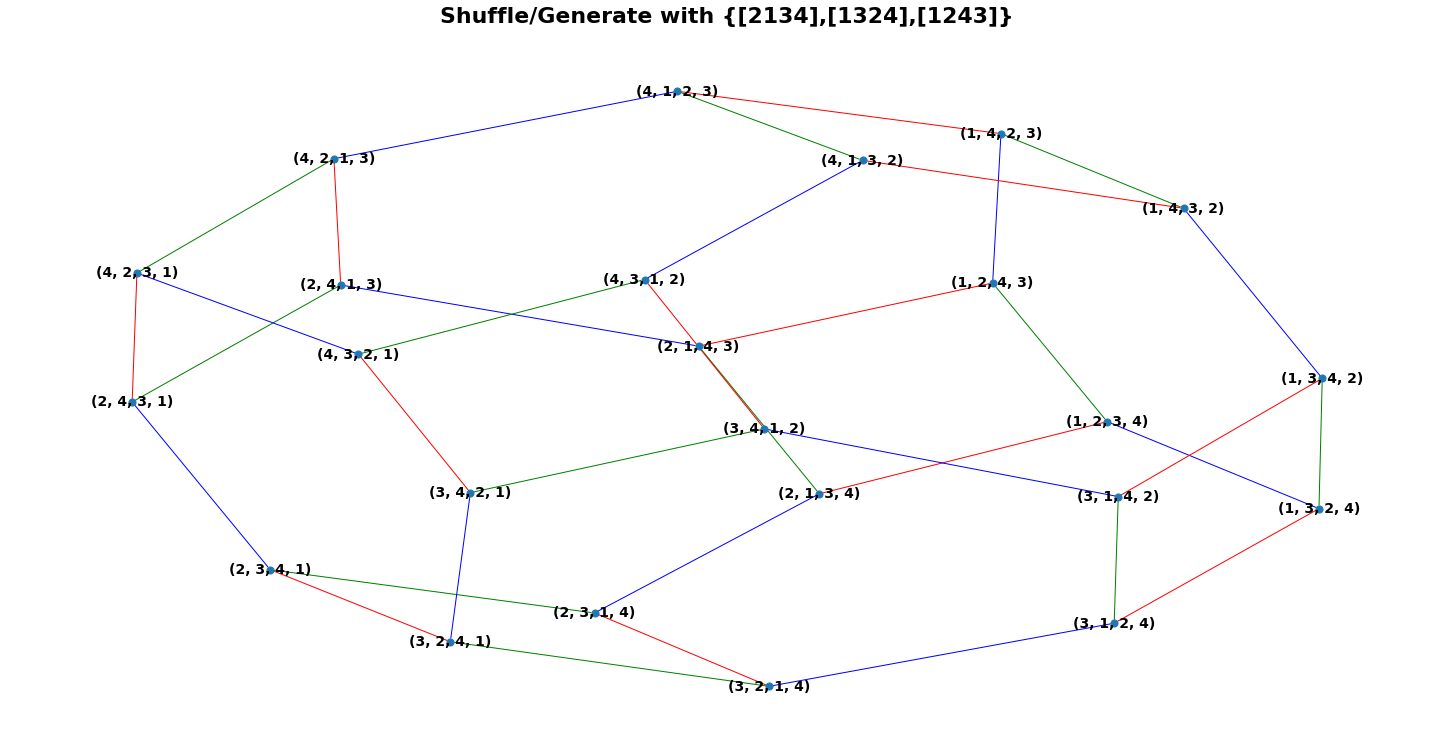

In [ ]:
"""
Tested on these sets: {[2134],[1324],[1243]}, {[2134],[1324],[1243],[4321]}, 
{[2134],[3214],[4231],[1324],[1432],[1243]}, {[2134],[2341]}, {[2134],[4231]}, 
{[2134],[3214],[4231]}
"""

# our group is S4 which we think of as a state of a deck of four cards
base_set = [1,2,3,4]
n = len(base_set)
sn = list(permutations(base_set, n))
num_perm = len(sn)

# Ask the user for a set of generators. Must use the full permutation notation
generators_str = input('Enter a list of generators or (1) for random transpositions shuffle or (2) for top-to-random shuffle: \n')
output = input('\nFull output? (0, 1) \n')
if output == '0':
  output = False
elif output == '1':
  output = True

# parse the input and create a list of generators
generators, generators_str = create_generators(generators_str)

# adjoin inverses to the generating set and create a list of edges to build the Cayley graph by multiplying group elements
edge_colors, _ = make_edges(generators)

# make the graph
G, G_colors = make_graph(edge_colors)

# quickly count the multiplicity of the largest eigenvalue up to some order of machine epsilon
A = nx.convert_matrix.to_numpy_array(G)
w_A, v_A = eigh(A)
max_eig = max(w_A)


if np.count_nonzero(abs(w_A-max_eig) <= 10*np.finfo(float).eps) == 1:
  generates = True
  print('\n' + generators_str + ' GENERATES S4 :) \n')
else:
  generates = False
  print('\n' + generators_str + ' DOES NOT GENERATE S4 :( \n')

if output:
  # quickly check if the matrix is symmetric
  sym_check = True

  for i in range(np.size(A,axis=0)):
    for j in range(np.size(A,axis=1)):
      if A[i,j] != A[j,i]:
        sym_check = False
        print('\nAdjacency matrix is not symmetric!')
        break

  if sym_check:
    print('\nAdjacency matrix is symmetric!')

  # print out information about the spectrum of the adjacency matrix
  print('\nThe eigenvalues of the adjecency matrix are: ' + str(np.around(w_A,decimals=2)) + '\n')
  print(str(abs(w_A-max_eig) <= 10*np.finfo(float).eps) + '\n')
  print('The multiplicity of the largest eigenvlaue is estimated to be : ' + str(np.count_nonzero(abs(w_A-max_eig) <= 10*np.finfo(float).eps)) + '\n')

# draw the graph
if generates:
  nx.draw(G, with_labels=True, edge_color=G_colors, node_size=50, font_weight='bold', font_size=14)
  plt.title('Shuffle/Generate with ' + generators_str, fontsize=22, fontweight='bold')
else:
  nx.draw(G, with_labels=True, edge_color=G_colors, node_size=50, font_weight='bold', font_size=14)
  plt.title('Shuffle/Generate with ' + generators_str, fontsize=22, fontweight='bold')

# get the diameter of the Cayley graph
diam = nx.algorithms.distance_measures.diameter(G)
print('The diameter of our Cayley graph is: ' + str(diam))

# Visualize the random walk on the Cayley graph

Create the stochastic matrix associated with the random walk on this graph


In [ ]:
# now get the adjacency matrix and turn it into the stochastic matrix associated with the simple random walk on this graph
A = nx.convert_matrix.to_numpy_array(G)
P = create_transition_matrix(A, generators)

Initialize the random walker at (1,2,3,4) and start to multiply by P. At each step we will re-weight the node sizes


In [ ]:
fig, ax = plt.subplots(figsize=(20,10))

def animate(i):
  ax.clear()
  pi = np.zeros((24,))
  pi[0] = 1
  pi = np.matmul(pi, np.linalg.matrix_power(P,i))
  node_sizes = list(pi*1500)
  nx.draw_kamada_kawai(G, with_labels=True, edge_color=G_colors, node_size=node_sizes, font_weight='bold', font_size=16)
  plt.title('Shuffle/Generate with ' + generators_str, fontsize=22, fontweight='bold')

rc('animation', html='jshtml')

FuncAnimation(fig, animate, frames=40)

Output hidden; open in https://colab.research.google.com to view.

Calculate the spectrum, spectral gap, relaxation time, and upper and lower bounds on mixing time

Our eigenvalues of P are: [1.   0.9  0.9  0.9  0.79 0.79 0.67 0.67 0.67 0.57 0.57 0.57 0.43 0.43
 0.43 0.33 0.33 0.33 0.21 0.21 0.1  0.1  0.1  0.  ]

Our absolute spectral gap is: 0.1

Our spectral gap is: 0.1

Our relaxation time is: 10.24

The upper bound on mixing time for eps=0.01 is: 79.72

The lower bound on mixing time for eps=0.01 is: 36.16



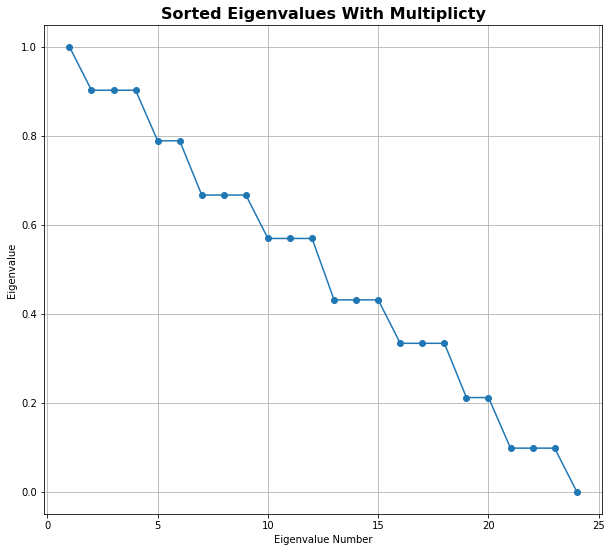

In [ ]:
spec_gap, _, t_rel_P, upper_bound, lower_bound, _ = get_spectrum(P, .01)

Plot the stationary distribution, distance to the uniform stationary distribution, and row entries over time

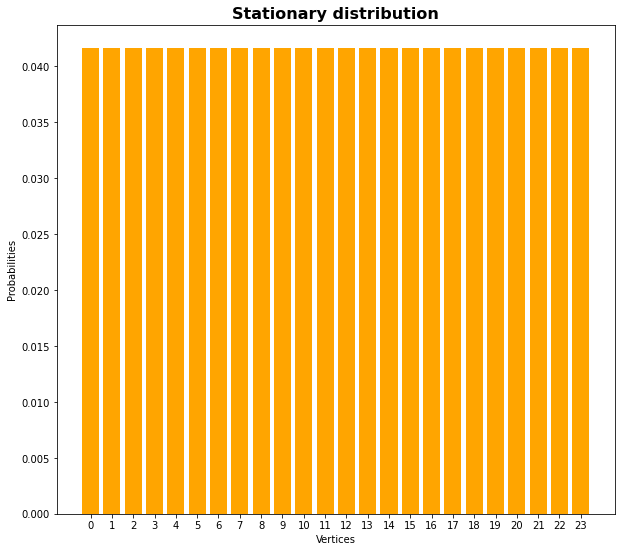

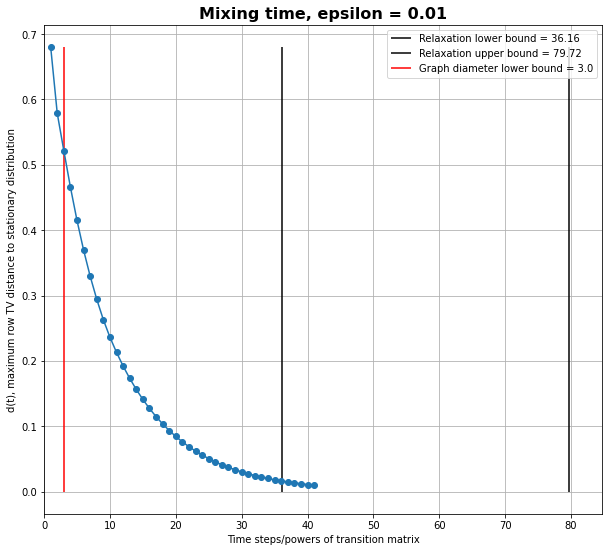

In [ ]:
# we want to be within .01 TV distance to the stationary distribution
eps = .01
vertices = [i for i in range(num_perm)]

# William's animation code
fig=plt.figure(figsize=(10,9))
barcollection = plt.bar(range(num_perm), np.ones(num_perm))
plt.xlabel('Vertices')
plt.ylabel('Probabilities')
plt.title('Maximally distant row distribution over time', fontsize=16, fontweight='bold')
plt.xticks(vertices, labels = [str(i) for i in range(num_perm)])
plt.close()

def animate(i):
  for j, bar in enumerate(barcollection):
    bar.set_height(distributions[i][j])

rc('animation', html='jshtml')

# we know that the stationary distribution for a random walk on a group is uniform
stat_distribution = np.ones((num_perm,))/num_perm
histograms(vertices, stat_distribution)
dist_vec, distributions = mixing_time(P, eps, stat_distribution)
plot_dist(dist_vec, eps, upper_bound, lower_bound, diam/2)

FuncAnimation(fig, animate, frames=len(dist_vec))

# Compare mixing times for different random walks (shuffles) on S4

Plot the Cayley graphs for three different shuffles

(0.0, 1.0, 0.0, 1.0)

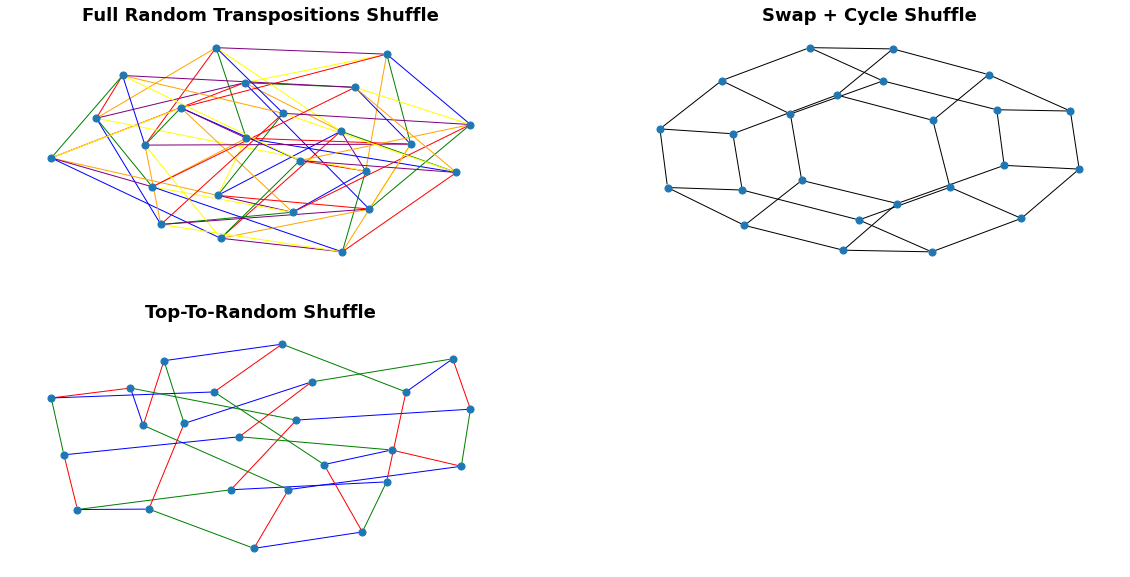

In [ ]:
# create a list of different generating sets corresponding to different shuffles
H = [[[2,1,3,4],[3,2,1,4],[4,2,3,1],[1,3,2,4],[1,4,3,2],[1,2,4,3]], [[2,1,3,4],[2,3,4,1]], [[2,1,3,4], [3,2,1,4], [4,2,3,1]]]
H_labels = ['{[2134],[3214],[4231],[1324],[1432],[1243]}', '{[2134],[2341]}', '{[2134],[3214],[4231]}']
titles = ['Full Random Transpositions Shuffle', 'Swap + Cycle Shuffle', 'Top-To-Random Shuffle']

fig, axs = plt.subplots(2,2,figsize=(20,10))
adjacency_matrices = []

for i, generators in enumerate(H):
  if generators == [[2,1,3,4],[2,3,4,1]]:
    edge_colors, _ = make_edges(generators, swap=False)
  else:
    edge_colors, _ = make_edges(generators)
  G = nx.Graph()
  G.add_nodes_from(sn)
  G.add_edges_from(edge_colors)
  G_colors = nx.get_edge_attributes(G,'color').values()
  adjacency_matrices.append(nx.convert_matrix.to_numpy_array(G))
  ix = np.unravel_index(i, axs.shape)
  plt.sca(axs[ix])
  nx.draw(G, edge_color=G_colors, node_size=50, ax=axs[ix])
  axs[ix].set_title(titles[i], fontsize=18, fontweight='bold')

axs[-1, -1].axis('off')

Plot the spectrum for each of the shuffles

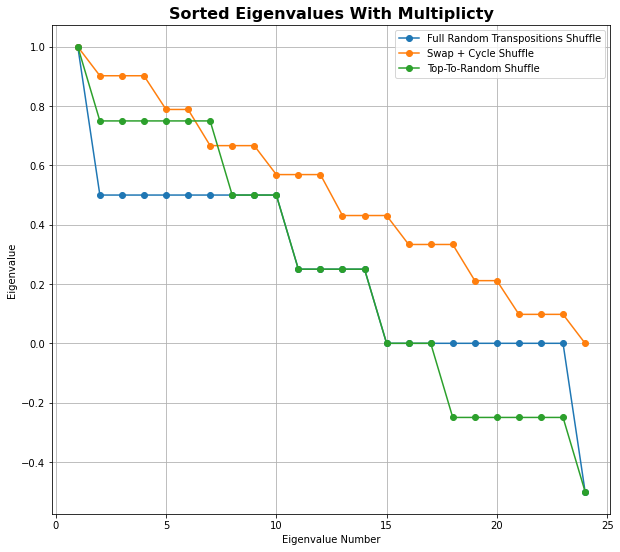

In [ ]:
transition_matrices = []
spec_gaps = []
eigenvalues = []

for i, matrix in enumerate(adjacency_matrices):
  P = create_transition_matrix(matrix, H[i])
  transition_matrices.append(P)
  spec_gap, _, t_rel_P, upper_bound, lower_bound, w_P = get_spectrum(P, .01, output=False)
  spec_gaps.append(spec_gap)
  eigenvalues.append(w_P)

plt.figure(figsize=(10,9))
x = np.linspace(1, num_perm, num=num_perm)
for i, eigv in enumerate(eigenvalues):
  plt.plot(x, eigv[::-1], marker='o', label=titles[i])

plt.xlabel('Eigenvalue Number')
plt.ylabel('Eigenvalue')
plt.title('Sorted Eigenvalues With Multiplicty', fontsize=16, fontweight='bold')
plt.legend()
plt.grid()

Plot distance to stationary for each of the shuffles

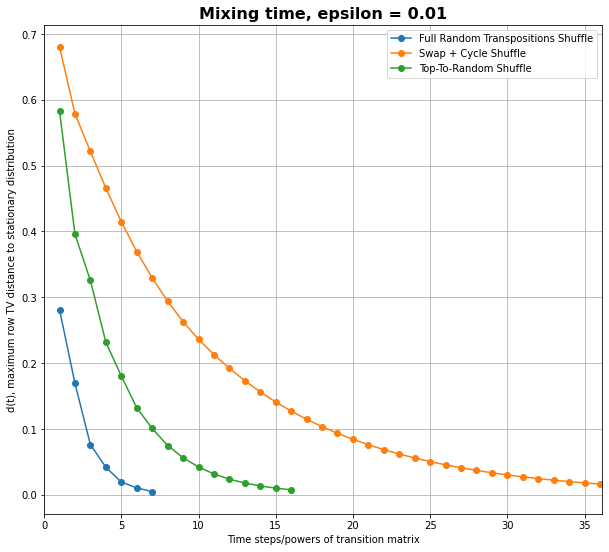

In [ ]:
plt.figure(figsize=(10,9))

for i, t in enumerate(transition_matrices):
  dist_vec, distributions = mixing_time(t, eps, stat_distribution)
  x = [j+1 for j in range(len(dist_vec))]
  y = dist_vec
  plt.plot(x, y, '-o', label=titles[i])
  plt.xlabel('Time steps/powers of transition matrix')
  plt.ylabel('d(t), maximum row TV distance to stationary distribution')
  plt.title('Mixing time, epsilon = ' + str(eps), fontsize=16, fontweight='bold')
  plt.xlim((0, upper_bound+5))
  plt.grid()

plt.legend()